##**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 3.5 MB/s 
     |████████████████████████████████| 3.5 MB 42.4 MB/s 
     |████████████████████████████████| 2.4 MB 36.6 MB/s 
     |████████████████████████████████| 709 kB 54.1 MB/s 
     |████████████████████████████████| 467 kB 2.1 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=aa4571c0bdd1026a9f52bd93a5122838b35360419c69d7733d5301bde3c10c03
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 2.1 MB/s 
     |████████████████████████████████| 9.8 MB 14.8 MB/s 
  Created wheel

In [ ]:
import scipy.io
import pandas as pd
import os
import random

import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gaddp

import numpy as np
import pickle

import pingouin
from scipy import signal

## Loading first dataset (working memory)

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
CURR_SUB = "sub-09"
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, os.path.join(CURR_SUB, "ProcessedData/data_ica.mat"))
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
DATA = "ProcessedData/data_ica.mat"

## Parameters

In [ ]:
NUM_EPOCHS = 400
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 34
VAL_BATCH_SIZE = 23
LEARNING_RATE = 0.001
embedding_size = 150

FEATURE_VERSION = "1.0.0"
SAVE_MODEL_VERSION = "1.0.0"
FEATURES_TYPE = "adj" #"adj" "plv" "svd"
MODEL_TYPE = "GCN_GL" #GCN
ADJ_MATRIX = "Learned"
CURR_DIR = "/content/drive/MyDrive/Tesi/Classification+GL/" + MODEL_TYPE + "/" + CURR_SUB + "/"
FEATURE_DIR = "/content/drive/MyDrive/Tesi/Classification/" + FEATURES_TYPE + "/" + CURR_SUB + "/"

if not os.path.isdir(CURR_DIR):
    os.mkdir(CURR_DIR)

saved_models_dir =  CURR_DIR + SAVE_MODEL_VERSION
features_dir = FEATURE_DIR + FEATURE_VERSION

print(saved_models_dir)
print(features_dir)

/content/drive/MyDrive/Tesi/Classification+GL/GCN_GL/sub-09/1.0.0
/content/drive/MyDrive/Tesi/Classification/adj/sub-09/1.0.0


## Single subject data

In [ ]:
mat = scipy.io.loadmat(SINGLE_SUBJECT)
trial = mat['trial']
trialinfo = mat['trialinfo']

In [ ]:
channels = []
for channel in mat['label']:
  channels.append(channel[0][0])

channels_list = ['Fp1','Fpz','Fp2',
    'AF3','AF4',
    'F7','F3','Fz','F4','F8',
    'FC5','FC1','FC2','FC6',
    'C3','Cz','C4',
    'CP5','CP1','CP2','CP6',
    'P5','P3','Pz','P4','P6',
    'POz','O1','O2']

indexes = []
for ch in channels_list:
  indexes.append(channels.index(ch))

In [ ]:
trials = []
labels = []
trial = np.transpose(np.squeeze(trial))
for i, t in enumerate(trial):
  trials.append(t[indexes, 1250:1750])
  labels.append(trialinfo[i, 5]-1)  #zero is stick, one is avatar --- the -1 to have labels with 0 or 1 values (in dataset are 1 and 2)

trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))
print(np.shape(trials))
print(np.shape(labels))

(224, 125, 29)
(224,)


#Pre-processing

## Utility

In [ ]:
def zscore_normalization(train_data, val_data, train_labels, val_labels):
  resting_state_train_idxs = [i for i, j in enumerate(train_labels) if j == 3]
  resting_state_val_idxs = [i for i, j in enumerate(val_labels) if j == 3]

  resting_state_train = list(map(train_data.__getitem__, resting_state_train_idxs))
  resting_state_val = list(map(val_data.__getitem__, resting_state_val_idxs))

  rs_avg_train = np.mean(resting_state_train)
  rs_std_train = np.std(resting_state_train)

  rs_avg_val = np.mean(resting_state_val)
  rs_std_val = np.std(resting_state_val)

  train_data = normalize_trials(train_data, rs_avg_train, rs_std_train)
  val_data = normalize_trials(val_data, rs_avg_val, rs_std_val)

  return train_data, val_data


def normalize_trials(trials, avg, std):
  norm_trials = []
  for t in trials:
    norm_trials.append((t- avg)/std)

  return norm_trials

def normalize_list(lst):
  return (lst - np.mean(lst))/np.std(lst)

def _normalize_trial_by_channel(trial):
  
  for i in range(22):
    ch_avg = np.mean(trial[:, i])
    ch_std = np.std(trial[:, i])
    trial[:, i] = (trial[:, i] - ch_avg)/ch_std

  return trial

def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

#print(np.mean(_normalize_trial(trials[0])))
#print(np.std(_normalize_trial(trials[0])))

In [ ]:
def adj_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())

  corr_matrix = _normalize_trial(corr_matrix)

  for i in range(np.shape(corr_matrix)[0]):
    feat.append(list(np.squeeze(corr_matrix[i, :])))

  return feat


def svd_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())
  #adj_matrix = np.round(corr_matrix)

  #corr_matrix = _normalize_trial(corr_matrix)

  #u, s, v = scipy.linalg.svd(adj_matrix)
  u, s, v = scipy.linalg.svd(corr_matrix)
  u = _normalize_trial(u)

  #corr_matrix = _normalize_trial(corr_matrix)

  for i in range(np.shape(u)[0]):
    feat.append(list(np.squeeze(u[i, :])))
    #feat.append(normalize_list(list(np.squeeze(u[:, i]))))


  #print(np.shape(feat))
  return feat

def phase_locking_value(theta1, theta2):
    complex_phase_diff = np.exp(complex(0,1)*(theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

def plv_corr_matrix(trial, num_channels):
  corr_matrix = np.zeros((num_channels,num_channels))
  for i in range(num_channels):
    for j in range(num_channels):
      corr_matrix[i, j] = phase_locking_value(trial[:, i], trial[:, j])
      corr_matrix[j, i] = phase_locking_value(trial[:, i], trial[:, j])
  
  return(corr_matrix)

def plv_features(trial):
  feat = []
  num_channels = np.shape(trial)[1]
  corr_matrix = _normalize_trial(plv_corr_matrix(trial, num_channels))

  for i in range(np.shape(corr_matrix)[0]):
    feat.append(list(np.squeeze(corr_matrix[i, :])))
  return feat

In [ ]:
def edge_index_computation(trial_p):
  starts = []
  stops = []
  trial_df = pd.DataFrame(trial_p)

  corr_matrix = np.array(trial_df.pcorr())                   #partial corr

  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return edge_indices

def random_connectivty(trial):
  starts = []
  stops = []
  corr_matrix = np.random.rand(29,29)
  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def fullyconnected_connectivty(trial):
  starts = []
  stops = []
  corr_matrix = np.ones((29,29))
  for i in range(np.shape(corr_matrix)[0]):
    for j in range(np.shape(corr_matrix)[0]):
      if corr_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def connectivity_estimate(trial):
  starts = []
  stops = []
  trial_df = pd.DataFrame(trial)

  corr_matrix = np.array(trial_df.pcorr())    #partial corr

  adj_matrix = np.round(np.abs(corr_matrix))
  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return corr_matrix, edge_indices

def get_features(trials, feats_type = "adj"):
  all_feats = []
  all_corr_matrix = []
  for trial in trials:
    if feats_type == "adj":
      all_feats.append(adj_features(trial))
    elif feats_type == "plv":
      all_feats.append(plv_features(trial))
    elif feats_type == "de":
      all_feats.append(DE_PSD(np.transpose(trial), stft_para))
    else:
      all_feats.append(svd_features(trial))

  return all_feats

def get_edges(trials):
  all_edges = []
  all_corr_matrices = []
  for trial in trials:
    curr_corr_mat, curr_edges = connectivity_estimate(trial)
    all_corr_matrices.append(curr_corr_mat)
    all_edges.append(curr_edges)

  return all_corr_matrices, all_edges

## Dataset

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self.features = get_features(trials, FEATURES_TYPE)
        self.corr_matrices, self.edges = get_edges(trials)
    
    def __len__(self):
      return len(self.trials)

    def __getitem__(self, idx):
        corr_matrix, edge_indices = connectivity_estimate(self.trials[idx])

        return Data(x = torch.tensor(self.features[idx]), \
                    edge_index = torch.tensor(self.edges[idx]), \
                    y = torch.tensor(self.labels[idx], dtype = torch.long), pcm = torch.tensor(self.corr_matrices[idx]))

In [ ]:
trials_0 = trials[:112]
trials_1 = trials[112:]

labels_0 = labels[:112]
labels_1 = labels[112:]

train_data_0 = trials_0[:83]
test_data_0 = trials_0[83:100]
val_data_0 = trials_0[100:]

train_data_1 = trials_1[:84]
test_data_1 = trials_1[84:101]
val_data_1 = trials_1[101:]

train_labels_0 = labels_0[:83]
test_labels_0 = labels_0[83:100]
val_labels_0 = labels_0[100:]

train_labels_1 = labels_1[:84]
test_labels_1 = labels_1[84:101]
val_labels_1 = labels_1[101:]

train_data = train_data_0 + train_data_1
val_data = val_data_0 + val_data_1
test_data = test_data_0 + test_data_1

train_labels = train_labels_0 + train_labels_1
val_labels = val_labels_0 + val_labels_1
test_labels = test_labels_0 + test_labels_1

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

print(val_labels.count(1)/len(val_labels))
print(test_labels.count(1)/len(test_labels))
print(train_labels.count(1)/len(train_labels))

(167, 125, 29)
(23, 125, 29)
(34, 125, 29)
0.4782608695652174
0.5
0.5029940119760479


##Alternative

In [ ]:
from sklearn.model_selection import train_test_split
seed = random.random()
random.seed(seed)
random.shuffle(trials)
random.seed(seed)
random.shuffle(labels)
num_trials = 224
train_val_data = trials[:int(0.85*num_trials)]
test_data = trials[int(0.85*num_trials):]

train_val_labels = labels[:int(0.85*num_trials)]
test_labels = labels[int(0.85*num_trials):]

train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.12)

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

# Show val dataset imbalance
print(val_labels.count(1)/len(val_labels))
print(test_labels.count(1)/len(test_labels))
print(train_labels.count(1)/len(train_labels))

(167, 125, 29)
(23, 125, 29)
(34, 125, 29)
0.5217391304347826
0.5
0.49700598802395207


##Dataset creation

In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)
test_dataset = EEG_dataset(test_data, test_labels)

print(next(iter(train_dataset)))
print(next(iter(val_dataset)))
print(next(iter(test_dataset)))

Data(x=[29, 29], edge_index=[2, 55], y=1, pcm=[29, 29])
Data(x=[29, 29], edge_index=[2, 61], y=1, pcm=[29, 29])
Data(x=[29, 29], edge_index=[2, 39], y=1, pcm=[29, 29])


## DataLoaders

In [ ]:
from torch_geometric.loader import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size= TRAIN_BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

print(next(iter(train_dataloader)))
print(next(iter(val_dataloader)))
print(next(iter(test_dataloader)))

DataBatch(x=[1856, 29], edge_index=[2, 2964], y=[64], pcm=[1856, 29], batch=[1856], ptr=[65])
DataBatch(x=[667, 29], edge_index=[2, 1051], y=[23], pcm=[667, 29], batch=[667], ptr=[24])
DataBatch(x=[986, 29], edge_index=[2, 1558], y=[34], pcm=[986, 29], batch=[986], ptr=[35])


#Network and Training

## Graph Learn

In [ ]:
import matplotlib.pyplot as plt
class Graph_Learn(torch.nn.Module):
    '''
    Graph structure learning (based on the middle time slice)
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_vertices, num_of_vertices)
    '''
    def __init__(self, alpha, **kwargs):
        super(Graph_Learn, self).__init__(**kwargs)
        self.alpha = alpha
        self.S = torch.Tensor([[[0.0]]])  # similar to placeholder
        self.diff = torch.Tensor([[[[0.0]]]])  # similar to placeholder
        a = torch.empty((29, 1), dtype = torch.double)
        a = torch.nn.init.uniform_(a, -0.05, 0.05)
        self.weight = torch.nn.Parameter(a)

    def forward(self, x):
        #Input:  [N, timesteps, vertices, features]
        N, T, V, F = x.size()
        
        # shape: (N,V,F) use the current slice (middle one slice)
        x = x[:,0,:,:]

        # shape: (N,V,V,F)
        diff = torch.permute(torch.permute(torch.broadcast_to(x,[V,N,V,F]), dims=(2,1,0,3))-x, dims=(1,0,2,3))

        # shape: (N,V,V)
        tmpS = torch.exp(torch.relu(torch.reshape(torch.matmul(torch.abs(diff).to(torch.double), self.weight), [N,V,V])))
        
        S = tmpS / torch.sum(tmpS,dim=1,keepdim=True)
        
        self.diff = diff
        self.S = S

        return S, diff, self.alpha

## Model

In [ ]:
class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h, drop):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(29, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)

        self.drop = torch.nn.Dropout(drop)

        self.out1 = Linear(dim_h, 100)
        self.out2 = Linear(100, 16)
        self.out3 = Linear(16, 1)

        self.gl = Graph_Learn(0.001)

    def extract_edges(self, m):
      starts, stops = [], []

      for k in range(m.size(dim = 0)):
        for i in range(m.size(dim = 1)):
          for j in range(m.size(dim = 1)):
            if not(k == 0):
              starts.append(i+ k*29)
              stops.append(j+ k*29)
            else:
              starts.append(i)
              stops.append(j)  

      return torch.tensor([starts,stops], dtype = torch.long)

    def forward(self, x, edge_index, batch):
        #x = x.to(torch.double)
        x_gl = torch.unsqueeze(torch.reshape(x, (int(x.size(dim = 0)/29), 29, 29)), 1)
        S, diff, alpha = self.gl(x_gl)
        edge_index_gl = self.extract_edges(S)

        weights = torch.flatten(S, 0, -1)

        # Node embeddings
        h = self.conv1(x, edge_index_gl, weights)
        h = h.relu()
        h = self.conv2(h.to(torch.float), edge_index_gl, weights)
        h = h.relu()

        # Graph-level readout
        hG = gaddp(h, batch)
        hG = hG.to(torch.float)
        # Classifier
        hidden = self.out1(hG)
        hidden = self.drop(hidden)
        
        hidden = self.out2(hidden)
        hidden = self.drop(hidden)
        
        hidden = self.out3(hidden)
        out = self.drop(hidden)

        out = torch.squeeze(out, dim = 1)
        out = torch.sigmoid(out)
        
        return out, hG, S, diff, alpha

## WANDB

In [ ]:
!pip install wandb
import wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 2.1 MB/s 
     |████████████████████████████████| 162 kB 51.0 MB/s 
     |████████████████████████████████| 181 kB 66.4 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 158 kB 52.8 MB/s 
     |████████████████████████████████| 157 kB 55.2 MB/s 
     |████████████████████████████████| 157 kB 49.8 MB/s 
     |████████████████████████████████| 157 kB 45.4 MB/s 
     |████████████████████████████████| 157 kB 67.5 MB/s 
     |████████████████████████████████| 157 kB 56.5 MB/s 
     |████████████████████████████████| 157 kB 55.0 MB/s 
     |████████████████████████████████| 157 kB 18.0 MB/s 
     |████████████████████████████████| 156 kB 52.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d483330f3e12ce25f9d80899c9e1e499629d2885de31684700dcd6fc32f5

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
run = wandb.init(
    project = "Tesi", 
    entity = "lorenzo_mattia",
    name = 'classification/'+ MODEL_TYPE +'_'+ CURR_SUB + '_' + SAVE_MODEL_VERSION,
    group = 'classification+GL_workMem_encoding_' + CURR_SUB,
    job_type = 'training',
    save_code = True,
    magic = True,
    config = {
        "EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "MODEL_TYPE": MODEL_TYPE,
        "TRAIN_BATCH_SIZE": TRAIN_BATCH_SIZE,
        "VAL_BATCH_SIZE": VAL_BATCH_SIZE,
        "TEST_BATCH_SIZE": TEST_BATCH_SIZE,
        "SAVED_MODEL_VERSION": SAVE_MODEL_VERSION,
        "EMBEDDING_SIZE": embedding_size,
        "FEATURES_TYPE": FEATURES_TYPE,
        "ADJ_MATRIX": ADJ_MATRIX
    }
)

## GL loss functions

In [ ]:
def diff_loss(diff, S):
    '''
    compute the 1st loss of L_{graph_learning}
    '''
    
    if len(S.shape)==3:
        # batch input
        return torch.mean(torch.sum(torch.sum(diff**2,dim=3, dtype = torch.double)*S, dim=(1,2)))
    else:
        return torch.sum(torch.sum(diff**2,dim=2)*S)


def F_norm_loss(S, Falpha):
    '''
    compute the 2nd loss of L_{graph_learning}
    '''
    if len(S.shape)==3:
        # batch input
        return Falpha * torch.sum(torch.mean(S**2,axis=0))
    else:
        return Falpha * torch.sum(S**2)

## GL training loop

In [ ]:
import matplotlib.pyplot as plt

def training_loop_gl(model, optimizer):
  train_acc, val_acc, ep, train_losses, val_losses = [], [], [], [], []
  best_acc = 0
  best_loss = 1000000
  for epoch in range(500):
      
      model.train()
      ep.append(epoch)
      n, d, n_v, d_v = 0, 0, 0, 0

      for batch in train_dataloader:
          optimizer.zero_grad()
          pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch) #, S, diff, alpha
          
          train_diff_l = diff_loss(diff, S)
          train_F_norm_l = F_norm_loss(S, alpha)
          train_l = loss_fn(pred, batch.y.float())
          train_loss =  train_l  + train_diff_l + train_F_norm_l
          
          pred = torch.round(pred)
          d += pred.shape[0]
          n += (batch.y.float() == pred).int().sum()

          train_loss.backward()
          optimizer.step()
      
      if epoch%5 == 0:
        temp = torch.mean(torch.reshape(S, (39, 29, 29)), dim = 0).detach().numpy()
        plt.imshow(temp)
        plt.show()
      
      model.train(False)
      for batch in val_dataloader:
        with torch.no_grad():
          pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch)
        
        val_diff_l = diff_loss(diff, S)
        val_F_norm_l = F_norm_loss(S, alpha)
        val_l = loss_fn(pred, batch.y.float())

        val_loss =  val_l  + val_diff_l + val_F_norm_l
        pred = torch.round(pred)
        d_v += pred.shape[0]
        n_v += (batch.y.float() == pred).int().sum()
        
      print("Epoch: " + str(epoch) + " Train loss: " + str(round(train_loss.item(), 3)) + " Train accuracy: " + str(round((n / d).item(), 3)) +\
            " Val loss: " + str(round(val_loss.item(), 3)) + " Val accuracy: " + str(round((n_v / d_v).item(), 3)))

        
      cur_acc = (n_v / d_v).item()

      train_acc.append((n / d).item())
      val_acc.append((n_v / d_v).item())
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())

      if best_loss > val_losses[-1]:
        best_loss = val_losses[-1]
        if not os.path.isdir(saved_models_dir):
          os.mkdir(saved_models_dir)
        torch.save(model.state_dict(), saved_models_dir + "/best_model")
      
      wandb.log({
        'Train loss': train_losses[-1],
        'Train diff loss': train_diff_l,
        'Train classification loss': train_l,
        'Train F_norm loss': train_F_norm_l,
        'Val loss': val_losses[-1],
        'Val diff loss': val_diff_l,
        'Val classification loss': val_l,
        'Val F_norm loss': val_F_norm_l,
        'Train acc': train_acc[-1],
        'Val acc': val_acc[-1]
      })
          
  return train_acc, val_acc, ep, train_losses, val_losses

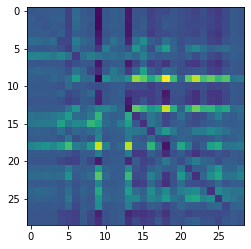

Epoch: 0 Train loss: 1667.292 Train accuracy: 0.509 Val loss: 1676.791 Val accuracy: 0.522
Epoch: 1 Train loss: 1668.192 Train accuracy: 0.473 Val loss: 1675.049 Val accuracy: 0.522
Epoch: 2 Train loss: 1668.751 Train accuracy: 0.413 Val loss: 1673.518 Val accuracy: 0.522
Epoch: 3 Train loss: 1668.691 Train accuracy: 0.521 Val loss: 1672.181 Val accuracy: 0.522
Epoch: 4 Train loss: 1664.032 Train accuracy: 0.491 Val loss: 1671.044 Val accuracy: 0.522


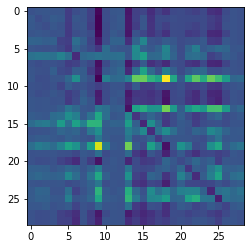

Epoch: 5 Train loss: 1668.83 Train accuracy: 0.455 Val loss: 1670.101 Val accuracy: 0.522
Epoch: 6 Train loss: 1669.09 Train accuracy: 0.515 Val loss: 1669.328 Val accuracy: 0.652
Epoch: 7 Train loss: 1666.397 Train accuracy: 0.545 Val loss: 1668.729 Val accuracy: 0.652
Epoch: 8 Train loss: 1666.24 Train accuracy: 0.533 Val loss: 1668.293 Val accuracy: 0.609
Epoch: 9 Train loss: 1665.338 Train accuracy: 0.581 Val loss: 1667.96 Val accuracy: 0.609


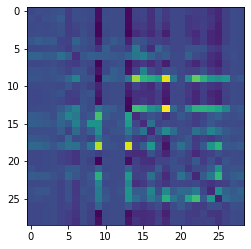

Epoch: 10 Train loss: 1662.629 Train accuracy: 0.587 Val loss: 1667.708 Val accuracy: 0.565
Epoch: 11 Train loss: 1665.093 Train accuracy: 0.617 Val loss: 1667.513 Val accuracy: 0.565
Epoch: 12 Train loss: 1663.981 Train accuracy: 0.593 Val loss: 1667.363 Val accuracy: 0.565
Epoch: 13 Train loss: 1668.379 Train accuracy: 0.617 Val loss: 1667.236 Val accuracy: 0.565
Epoch: 14 Train loss: 1665.476 Train accuracy: 0.587 Val loss: 1667.131 Val accuracy: 0.565


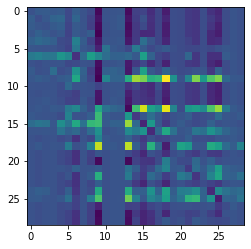

Epoch: 15 Train loss: 1665.411 Train accuracy: 0.647 Val loss: 1667.045 Val accuracy: 0.522
Epoch: 16 Train loss: 1661.447 Train accuracy: 0.605 Val loss: 1666.974 Val accuracy: 0.522
Epoch: 17 Train loss: 1662.252 Train accuracy: 0.617 Val loss: 1666.914 Val accuracy: 0.565
Epoch: 18 Train loss: 1660.149 Train accuracy: 0.593 Val loss: 1666.864 Val accuracy: 0.609
Epoch: 19 Train loss: 1662.524 Train accuracy: 0.611 Val loss: 1666.818 Val accuracy: 0.609


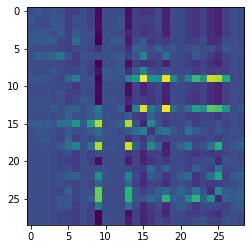

Epoch: 20 Train loss: 1665.893 Train accuracy: 0.617 Val loss: 1666.778 Val accuracy: 0.652
Epoch: 21 Train loss: 1664.719 Train accuracy: 0.575 Val loss: 1666.746 Val accuracy: 0.652
Epoch: 22 Train loss: 1665.397 Train accuracy: 0.635 Val loss: 1666.719 Val accuracy: 0.652
Epoch: 23 Train loss: 1664.861 Train accuracy: 0.677 Val loss: 1666.695 Val accuracy: 0.652
Epoch: 24 Train loss: 1665.3 Train accuracy: 0.659 Val loss: 1666.674 Val accuracy: 0.652


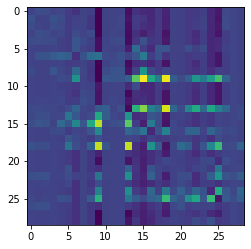

Epoch: 25 Train loss: 1663.07 Train accuracy: 0.665 Val loss: 1666.655 Val accuracy: 0.696
Epoch: 26 Train loss: 1667.274 Train accuracy: 0.725 Val loss: 1666.637 Val accuracy: 0.696
Epoch: 27 Train loss: 1664.8 Train accuracy: 0.683 Val loss: 1666.619 Val accuracy: 0.652
Epoch: 28 Train loss: 1660.294 Train accuracy: 0.635 Val loss: 1666.606 Val accuracy: 0.652
Epoch: 29 Train loss: 1665.744 Train accuracy: 0.725 Val loss: 1666.595 Val accuracy: 0.652


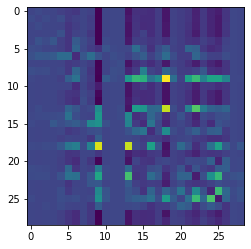

Epoch: 30 Train loss: 1667.489 Train accuracy: 0.653 Val loss: 1666.585 Val accuracy: 0.652
Epoch: 31 Train loss: 1663.753 Train accuracy: 0.689 Val loss: 1666.574 Val accuracy: 0.652
Epoch: 32 Train loss: 1665.096 Train accuracy: 0.707 Val loss: 1666.564 Val accuracy: 0.652
Epoch: 33 Train loss: 1662.629 Train accuracy: 0.683 Val loss: 1666.554 Val accuracy: 0.652
Epoch: 34 Train loss: 1663.372 Train accuracy: 0.641 Val loss: 1666.545 Val accuracy: 0.652


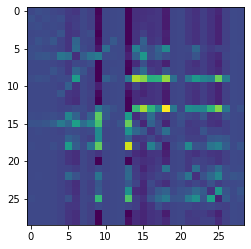

Epoch: 35 Train loss: 1662.32 Train accuracy: 0.671 Val loss: 1666.537 Val accuracy: 0.652
Epoch: 36 Train loss: 1663.304 Train accuracy: 0.695 Val loss: 1666.528 Val accuracy: 0.652
Epoch: 37 Train loss: 1666.046 Train accuracy: 0.719 Val loss: 1666.519 Val accuracy: 0.652
Epoch: 38 Train loss: 1663.265 Train accuracy: 0.683 Val loss: 1666.511 Val accuracy: 0.652
Epoch: 39 Train loss: 1664.112 Train accuracy: 0.647 Val loss: 1666.504 Val accuracy: 0.652


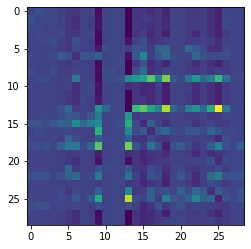

Epoch: 40 Train loss: 1664.401 Train accuracy: 0.695 Val loss: 1666.496 Val accuracy: 0.652
Epoch: 41 Train loss: 1664.18 Train accuracy: 0.641 Val loss: 1666.489 Val accuracy: 0.652
Epoch: 42 Train loss: 1662.649 Train accuracy: 0.677 Val loss: 1666.482 Val accuracy: 0.652
Epoch: 43 Train loss: 1663.6 Train accuracy: 0.737 Val loss: 1666.476 Val accuracy: 0.652
Epoch: 44 Train loss: 1663.245 Train accuracy: 0.695 Val loss: 1666.47 Val accuracy: 0.652


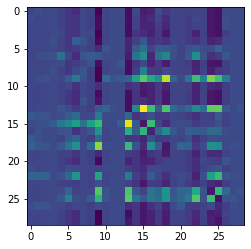

Epoch: 45 Train loss: 1665.713 Train accuracy: 0.623 Val loss: 1666.465 Val accuracy: 0.652
Epoch: 46 Train loss: 1661.538 Train accuracy: 0.701 Val loss: 1666.46 Val accuracy: 0.652
Epoch: 47 Train loss: 1667.133 Train accuracy: 0.695 Val loss: 1666.455 Val accuracy: 0.652
Epoch: 48 Train loss: 1664.704 Train accuracy: 0.725 Val loss: 1666.45 Val accuracy: 0.652
Epoch: 49 Train loss: 1666.509 Train accuracy: 0.737 Val loss: 1666.445 Val accuracy: 0.652


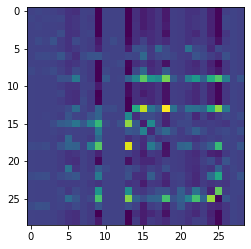

Epoch: 50 Train loss: 1663.224 Train accuracy: 0.737 Val loss: 1666.439 Val accuracy: 0.652
Epoch: 51 Train loss: 1665.5 Train accuracy: 0.713 Val loss: 1666.434 Val accuracy: 0.696
Epoch: 52 Train loss: 1663.05 Train accuracy: 0.731 Val loss: 1666.429 Val accuracy: 0.696
Epoch: 53 Train loss: 1664.966 Train accuracy: 0.743 Val loss: 1666.424 Val accuracy: 0.696
Epoch: 54 Train loss: 1663.131 Train accuracy: 0.76 Val loss: 1666.419 Val accuracy: 0.696


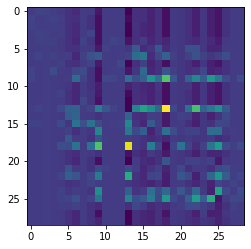

Epoch: 55 Train loss: 1665.243 Train accuracy: 0.689 Val loss: 1666.415 Val accuracy: 0.696
Epoch: 56 Train loss: 1667.449 Train accuracy: 0.719 Val loss: 1666.41 Val accuracy: 0.696
Epoch: 57 Train loss: 1666.727 Train accuracy: 0.707 Val loss: 1666.406 Val accuracy: 0.696
Epoch: 58 Train loss: 1667.282 Train accuracy: 0.707 Val loss: 1666.401 Val accuracy: 0.696
Epoch: 59 Train loss: 1664.241 Train accuracy: 0.737 Val loss: 1666.398 Val accuracy: 0.696


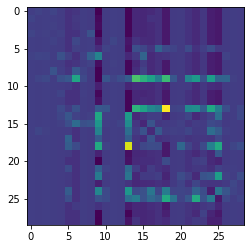

Epoch: 60 Train loss: 1661.123 Train accuracy: 0.719 Val loss: 1666.393 Val accuracy: 0.696
Epoch: 61 Train loss: 1664.804 Train accuracy: 0.749 Val loss: 1666.389 Val accuracy: 0.696
Epoch: 62 Train loss: 1663.092 Train accuracy: 0.677 Val loss: 1666.385 Val accuracy: 0.696
Epoch: 63 Train loss: 1665.265 Train accuracy: 0.689 Val loss: 1666.382 Val accuracy: 0.696
Epoch: 64 Train loss: 1664.117 Train accuracy: 0.731 Val loss: 1666.378 Val accuracy: 0.696


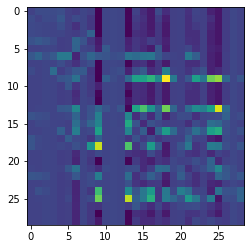

Epoch: 65 Train loss: 1664.976 Train accuracy: 0.719 Val loss: 1666.375 Val accuracy: 0.739
Epoch: 66 Train loss: 1664.118 Train accuracy: 0.731 Val loss: 1666.371 Val accuracy: 0.739
Epoch: 67 Train loss: 1663.856 Train accuracy: 0.731 Val loss: 1666.369 Val accuracy: 0.696
Epoch: 68 Train loss: 1664.094 Train accuracy: 0.689 Val loss: 1666.368 Val accuracy: 0.696
Epoch: 69 Train loss: 1663.22 Train accuracy: 0.737 Val loss: 1666.365 Val accuracy: 0.696


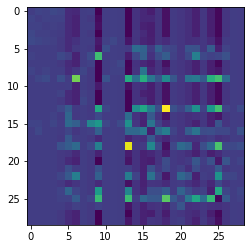

Epoch: 70 Train loss: 1662.548 Train accuracy: 0.766 Val loss: 1666.361 Val accuracy: 0.696
Epoch: 71 Train loss: 1665.302 Train accuracy: 0.737 Val loss: 1666.357 Val accuracy: 0.696
Epoch: 72 Train loss: 1660.6 Train accuracy: 0.725 Val loss: 1666.353 Val accuracy: 0.739
Epoch: 73 Train loss: 1668.875 Train accuracy: 0.772 Val loss: 1666.348 Val accuracy: 0.739
Epoch: 74 Train loss: 1665.534 Train accuracy: 0.713 Val loss: 1666.345 Val accuracy: 0.739


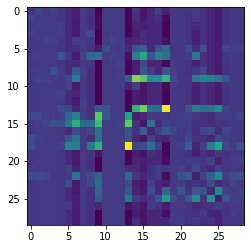

Epoch: 75 Train loss: 1665.163 Train accuracy: 0.784 Val loss: 1666.342 Val accuracy: 0.739
Epoch: 76 Train loss: 1661.896 Train accuracy: 0.778 Val loss: 1666.341 Val accuracy: 0.739
Epoch: 77 Train loss: 1664.185 Train accuracy: 0.731 Val loss: 1666.34 Val accuracy: 0.739
Epoch: 78 Train loss: 1663.227 Train accuracy: 0.784 Val loss: 1666.337 Val accuracy: 0.739
Epoch: 79 Train loss: 1664.552 Train accuracy: 0.737 Val loss: 1666.334 Val accuracy: 0.696


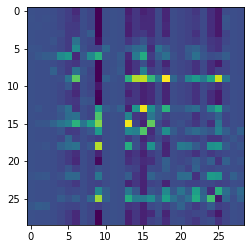

Epoch: 80 Train loss: 1668.98 Train accuracy: 0.749 Val loss: 1666.331 Val accuracy: 0.696
Epoch: 81 Train loss: 1659.258 Train accuracy: 0.772 Val loss: 1666.331 Val accuracy: 0.739
Epoch: 82 Train loss: 1664.593 Train accuracy: 0.754 Val loss: 1666.331 Val accuracy: 0.739
Epoch: 83 Train loss: 1665.406 Train accuracy: 0.814 Val loss: 1666.329 Val accuracy: 0.739
Epoch: 84 Train loss: 1662.909 Train accuracy: 0.76 Val loss: 1666.326 Val accuracy: 0.696


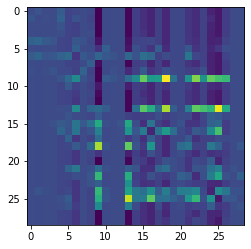

Epoch: 85 Train loss: 1664.915 Train accuracy: 0.737 Val loss: 1666.325 Val accuracy: 0.696
Epoch: 86 Train loss: 1664.151 Train accuracy: 0.814 Val loss: 1666.325 Val accuracy: 0.696
Epoch: 87 Train loss: 1658.936 Train accuracy: 0.808 Val loss: 1666.327 Val accuracy: 0.696
Epoch: 88 Train loss: 1663.598 Train accuracy: 0.796 Val loss: 1666.328 Val accuracy: 0.739
Epoch: 89 Train loss: 1663.88 Train accuracy: 0.796 Val loss: 1666.33 Val accuracy: 0.739


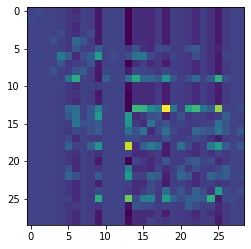

Epoch: 90 Train loss: 1663.371 Train accuracy: 0.784 Val loss: 1666.33 Val accuracy: 0.739
Epoch: 91 Train loss: 1663.542 Train accuracy: 0.772 Val loss: 1666.329 Val accuracy: 0.696
Epoch: 92 Train loss: 1662.999 Train accuracy: 0.784 Val loss: 1666.326 Val accuracy: 0.696
Epoch: 93 Train loss: 1664.589 Train accuracy: 0.826 Val loss: 1666.324 Val accuracy: 0.696
Epoch: 94 Train loss: 1665.928 Train accuracy: 0.802 Val loss: 1666.324 Val accuracy: 0.696


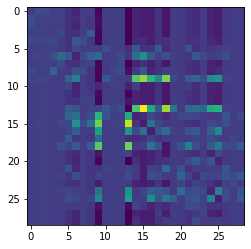

Epoch: 95 Train loss: 1665.776 Train accuracy: 0.82 Val loss: 1666.323 Val accuracy: 0.696
Epoch: 96 Train loss: 1664.523 Train accuracy: 0.82 Val loss: 1666.323 Val accuracy: 0.696
Epoch: 97 Train loss: 1662.704 Train accuracy: 0.802 Val loss: 1666.324 Val accuracy: 0.696
Epoch: 98 Train loss: 1662.664 Train accuracy: 0.844 Val loss: 1666.324 Val accuracy: 0.696
Epoch: 99 Train loss: 1663.073 Train accuracy: 0.82 Val loss: 1666.323 Val accuracy: 0.696


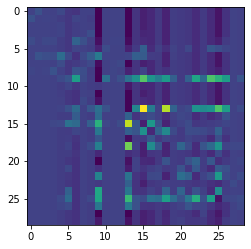

Epoch: 100 Train loss: 1664.36 Train accuracy: 0.784 Val loss: 1666.323 Val accuracy: 0.696
Epoch: 101 Train loss: 1664.679 Train accuracy: 0.808 Val loss: 1666.325 Val accuracy: 0.696
Epoch: 102 Train loss: 1662.241 Train accuracy: 0.814 Val loss: 1666.324 Val accuracy: 0.696
Epoch: 103 Train loss: 1661.289 Train accuracy: 0.838 Val loss: 1666.321 Val accuracy: 0.696
Epoch: 104 Train loss: 1666.425 Train accuracy: 0.802 Val loss: 1666.318 Val accuracy: 0.696


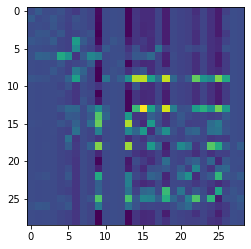

Epoch: 105 Train loss: 1664.239 Train accuracy: 0.79 Val loss: 1666.316 Val accuracy: 0.696
Epoch: 106 Train loss: 1660.557 Train accuracy: 0.778 Val loss: 1666.314 Val accuracy: 0.696
Epoch: 107 Train loss: 1661.71 Train accuracy: 0.85 Val loss: 1666.313 Val accuracy: 0.696
Epoch: 108 Train loss: 1666.11 Train accuracy: 0.844 Val loss: 1666.313 Val accuracy: 0.696
Epoch: 109 Train loss: 1664.772 Train accuracy: 0.832 Val loss: 1666.312 Val accuracy: 0.696


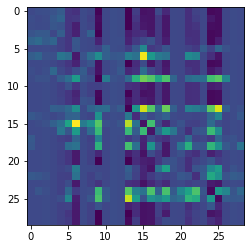

Epoch: 110 Train loss: 1665.056 Train accuracy: 0.79 Val loss: 1666.312 Val accuracy: 0.696
Epoch: 111 Train loss: 1664.85 Train accuracy: 0.802 Val loss: 1666.311 Val accuracy: 0.696
Epoch: 112 Train loss: 1663.335 Train accuracy: 0.826 Val loss: 1666.309 Val accuracy: 0.696
Epoch: 113 Train loss: 1662.993 Train accuracy: 0.814 Val loss: 1666.31 Val accuracy: 0.696
Epoch: 114 Train loss: 1662.648 Train accuracy: 0.832 Val loss: 1666.312 Val accuracy: 0.696


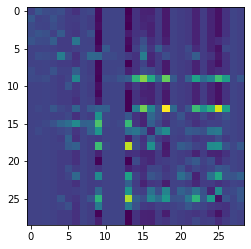

Epoch: 115 Train loss: 1662.931 Train accuracy: 0.856 Val loss: 1666.313 Val accuracy: 0.696
Epoch: 116 Train loss: 1663.191 Train accuracy: 0.82 Val loss: 1666.314 Val accuracy: 0.696
Epoch: 117 Train loss: 1663.58 Train accuracy: 0.844 Val loss: 1666.319 Val accuracy: 0.696
Epoch: 118 Train loss: 1663.827 Train accuracy: 0.82 Val loss: 1666.329 Val accuracy: 0.696


KeyboardInterrupt: ignored

In [ ]:
model = GCN(128, 0.2)
continue_training = False
if continue_training:
  LOAD_MODEL_VERSION = "1.0.0"
  model.load_state_dict(torch.load(CURR_DIR \
                    + LOAD_MODEL_VERSION + "/best_model"))
  
loss_fn = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
train_acc, val_acc, ep, train_losses, val_losses = training_loop_gl(model, optimizer)

In [ ]:
run.finish()

Train F_norm loss,█▇▅▃▃▃▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
Train acc,▁▁▁▂▃▄▃▂▄▅▄▅▅▄▅▃▆▅▆▅▅▅▆▆▆▇▇▇▆▇▇███▇▇█▇██
Train classification loss,█▇▇▇▆▇▆▆▆▆▆▆▅▆▆▆▅▅▅▄▄▅▄▄▃▅▄▂▂▂▄▂▁▂▂▂▁▃▁▃
Train diff loss,▇██▅▄▅▂▅▅▅▇▃▄▅▃▆▅▆▄▆▂▅▅▄▂▅▄▁▄▁▄▅▅▄▃▅▆▅▄▄
Train loss,▇██▅▄▅▂▅▅▅▇▄▄▅▄▆▅▆▄▆▃▅▅▄▂▅▄▁▄▁▄▅▅▄▃▅▆▅▄▄
Val F_norm loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▁▁▅▄▂▁▄▅▅▅▅▅▅▅▅▅▅▇▇▇▇▇█▇████▇▇█▇▇▇▇▇▇▇▇▇
Val classification loss,█▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂
Val diff loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train F_norm loss,0.0001


## Normal Test

In [ ]:
LOAD_MODEL_VERSION = "1.0.0"
model = GCN(128, 0.2)
model.load_state_dict(torch.load(CURR_DIR \
                   + LOAD_MODEL_VERSION + "/best_model"))
model.eval()

GCN(
  (conv1): GCNConv(29, 128)
  (conv2): GCNConv(128, 128)
  (drop): Dropout(p=0.2, inplace=False)
  (out1): Linear(in_features=128, out_features=100, bias=True)
  (out2): Linear(in_features=100, out_features=16, bias=True)
  (out3): Linear(in_features=16, out_features=1, bias=True)
  (gl): Graph_Learn()
)

In [ ]:
print(val_losses.index(min(val_losses)))
print(min(val_losses))
print(val_acc[val_losses.index(min(val_losses))])

499
1591.6328967842744
0.695652186870575


torch.Size([2, 28594])
Partial correlation adjacency mat


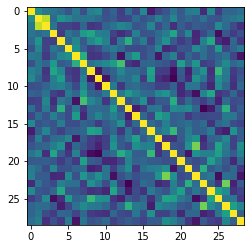

Learned adjacency mat


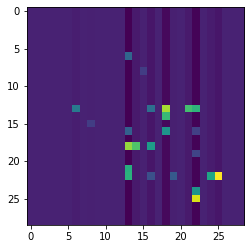

Average learned adjacency mat non soc


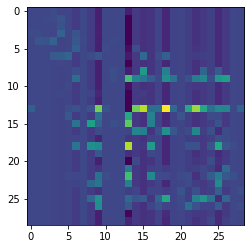

Average learned adjacency mat soc


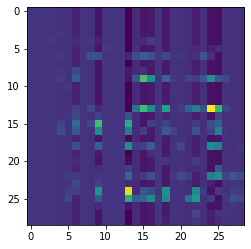

Average Partial adjacency mat non soc


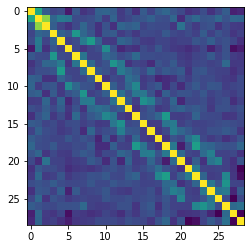

Average Partial adjacency mat soc


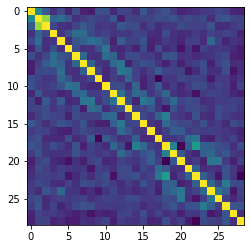

0.0
1
tensor([[ 1.0000,  0.2532,  0.1125,  0.1006,  0.0298, -0.0879,  0.1150, -0.1163,
          0.1684,  0.2176, -0.1158, -0.0122, -0.2028,  0.0607, -0.1540,  0.2272,
         -0.3550, -0.1833, -0.0852,  0.0926, -0.0616,  0.1378,  0.1608, -0.2901,
          0.2188, -0.2182,  0.0055,  0.0077,  0.0617],
        [ 0.2532,  1.0000,  0.8555,  0.0324,  0.2905,  0.1980,  0.0923,  0.1019,
          0.0989,  0.0227, -0.0972, -0.0452, -0.1830, -0.1661,  0.0449, -0.1039,
         -0.0252,  0.1550, -0.0032,  0.2100, -0.0429,  0.0362, -0.0531,  0.0797,
         -0.0655, -0.0942,  0.0603,  0.0983,  0.1446],
        [ 0.1125,  0.8555,  1.0000,  0.0981, -0.1886, -0.1720, -0.2219,  0.0075,
         -0.2522, -0.2192,  0.0067,  0.0821,  0.2030,  0.1401, -0.0874, -0.0448,
          0.2057, -0.1316,  0.0123, -0.2693, -0.0273, -0.1331, -0.0426, -0.0673,
         -0.1102,  0.2261,  0.0414, -0.1327, -0.2765],
        [ 0.1006,  0.0324,  0.0981,  1.0000, -0.2142,  0.0968,  0.0091,  0.3165,
          0.3969,  

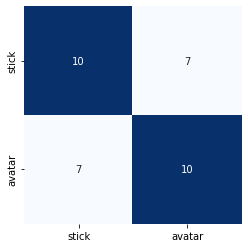

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def test(save = True):
  preds = []
  lbls = []
  for test_batch in train_dataloader:
    with torch.no_grad():
        #model.eval()
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch, TRAIN_BATCH_SIZE, test_batch.pcm)
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]

  conf_mat = confusion_matrix(lbls, preds)
  conf_mat = sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', \
                        cbar=False, xticklabels = ["stick", "avatar"], yticklabels = ["stick", "avatar"])
  
  if save:
    conf_mat.figure.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/confusion_matrix.png")

  print(classification_report(lbls, preds, target_names=["stick", "avatar"]))


def test_gl(save = True):
  preds = []
  lbls = []
  for test_batch in test_dataloader:
    with torch.no_grad():
        model.eval()
        pred, embed, S, _, _ = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  edges = model.extract_edges(S)
  print(edges.shape)
  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]
  indexes_non_soc = torch.tensor([i for i,val in enumerate(lbls) if val==0])
  indexes_soc = torch.tensor([i for i,val in enumerate(lbls) if val==1])

  temp = torch.reshape(test_batch.pcm, (TEST_BATCH_SIZE, 29, 29))
  temp2 = torch.reshape(S, (TEST_BATCH_SIZE, 29, 29))

  torch.save(torch.index_select(temp2, dim = 0, index = indexes_non_soc), CURR_DIR + LOAD_MODEL_VERSION + '/all_learned_non_soc.pt')
  torch.save(torch.index_select(temp2, dim = 0, index = indexes_soc), CURR_DIR + LOAD_MODEL_VERSION + '/all_learned_soc.pt')

  learned_non_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_non_soc), dim = 0)
  learned_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_soc), dim = 0)

  non_soc = torch.mean(torch.index_select(temp, dim = 0, index = indexes_non_soc), dim = 0)
  soc = torch.mean(torch.index_select(temp, dim = 0, index = indexes_soc), dim = 0)

  #temp_avg2 = torch.mean(temp2, dim = 0)
  #temp_avg = torch.mean(temp, dim = 0)
  gl_slice = 10
  print("Partial correlation adjacency mat")
  plt.imshow(temp[gl_slice])
  plt.show()

  print("Learned adjacency mat")
  plt.imshow(temp2[gl_slice])
  plt.show()

  print("Average learned adjacency mat non soc")
  plt.imshow(learned_non_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat non soc.png")
  plt.show()
  torch.save(learned_non_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_non_soc.pt') 
  
  print("Average learned adjacency mat soc")
  plt.imshow(learned_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat soc.png")
  plt.show()
  torch.save(learned_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_soc.pt') 

  print("Average Partial adjacency mat non soc")
  plt.imshow(non_soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average pearson adjacency mat non soc.png")
  plt.show()
  
  print("Average Partial adjacency mat soc")
  plt.imshow(soc)
  plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average pearson adjacency mat soc.png")
  plt.show()
  

  print(preds[gl_slice])
  print(lbls[gl_slice])
  print(temp[gl_slice])
  print(temp2[gl_slice])

  conf_mat = confusion_matrix(lbls, preds)
  conf_mat = sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', \
                        cbar=False, xticklabels = ["stick", "avatar"], yticklabels = ["stick", "avatar"])
  
  if save:
    conf_mat.figure.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/confusion_matrix.png")

  print(classification_report(lbls, preds, target_names=["stick", "avatar"]))

test_gl(True)

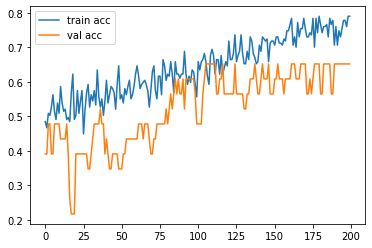

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(ep, train_acc, val_acc, save = True):
  plt.plot(ep, train_acc, label = 'train acc')
  plt.plot(ep, val_acc, label = 'val acc')
  #plt.plot(ep, val_acc, label = 'val acc')
  plt.legend()
  if save:
    plt.savefig(saved_models_dir + "/accuracy.png")

plot_acc(ep, train_acc, val_acc)

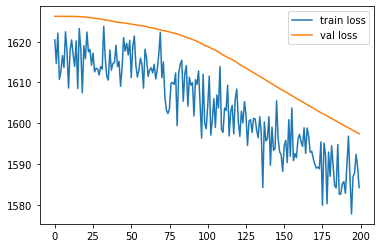

In [ ]:
def plot_loss(ep, t_loss, v_loss, save = True):
  plt.plot(ep, t_loss, label = 'train loss')
  plt.plot(ep, v_loss, label = 'val loss')
  #plt.plot(ep, val_acc, label = 'val acc')
  plt.legend()
  if save:
    plt.savefig(saved_models_dir + "/loss.png")

plot_loss(ep, train_losses, val_losses)